In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import graphviz
import math
import os
os.environ["PATH"] = "/opt/local/bin:" + os.environ["PATH"]
from graphviz import Digraph

In [2]:
import os
print(os.environ["PATH"])

/opt/local/bin:/Users/mikuangyi/Desktop/RecoveredDesktop_Archive-1/ak-neural-network/ak_venv/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public


In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:
      
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

20


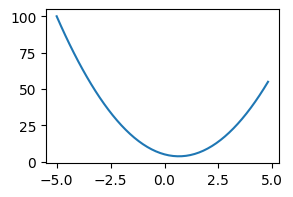

In [5]:
## part 1: f(x) = 3*x**2 - 4*x + 5
def f(x):
    return 3*x**2 - 4*x + 5
y = f(3)
print(y)
x_list = np.arange(-5, 5, 0.2)
y_list = [f(x) for x in x_list]
plt.figure(figsize = (3,2))
plt.plot(x_list, y_list)


In [6]:
## L = ab + c ##
a = 2
b = -3
c = 10
f = -2
e = a*b 
d = e + c
L = d*f

In [7]:
## approximate partial derivative with delta (direct)
delta = 0.0001

f_ = f + delta
L_ = d*f_
dLdf = (L_ - L)/ delta
print('dL/df = ', f"{dLdf:.4f}") 
print('---------------')
d_ = d + delta 
L_ = d_*f 
dLdd = (L_ - L)/ delta
print('dL/dd = ', f"{dLdd:.4f}")
print('---------------')
e_ = e + delta 
L_ = (e_ + c) * f 
dLde  = (L_ - L)/ delta
print('dL/de = ', f"{dLde: .4f}") 
print('---------------')
c_ = c + delta 
L_ = (e + c_) * f
dLdc = (L_ - L)/ delta
print('dL/dc = ', f"{dLdc: .4f}") 
print('---------------')
a_ = a + delta 
L_ = ((a_*b) + c) * f
dLda = (L_ - L)/ delta
print('dL/da = ', f"{dLda: .4f}") 
print('---------------')
b_ = b + delta 
L_ = ((a*b_) + c) * f
dLdb = (L_ - L)/ delta
print('dL/db = ', f"{dLdb: .4f}")


dL/df =  4.0000
---------------
dL/dd =  -2.0000
---------------
dL/de =  -2.0000
---------------
dL/dc =  -2.0000
---------------
dL/da =   6.0000
---------------
dL/db =  -4.0000


In [8]:
## approximate partial derivative with delta (chain rule)
delta = 0.0001

f_ = f + delta
L_ = d*f_
dLdf = (L_ - L)/ delta
print('dL/df = ', f"{dLdf:.4f}") 
print('---------------')
d_ = d + delta 
L_ = d_*f 
dLdd = (L_ - L)/ delta
print('dL/dd = ', f"{dLdd:.4f}")
print('---------------')
e_ = e + delta
d_ = e_ + c 
ddde = (d_ - d)/(e_ - e)
dLde = dLdd * ddde
print('dL/de = ', f"{dLde: .4f}") 
print('---------------')
c_ = c + delta 
d_ = (e + c_)
dddc = (d_ - d)/(c_ - c)
dLdc = (L_ - L)/ delta
print('dL/dc = ', f"{dLdc: .4f}") 
print('---------------')
a_ = a + delta 
e_ = (a_*b)
deda = (e_ - e) / (a_ - a)
dLda = dLdd * ddde * deda
print('dL/da = ', f"{dLda: .4f}") 
print('---------------')
b_ = b + delta 
e_ = (a*b_)
dedb = (e_ - e) / (b_ - b)
dLdb = dLdd * ddde * dedb
print('dL/db = ', f"{dLdb: .4f}")


dL/df =  4.0000
---------------
dL/dd =  -2.0000
---------------
dL/de =  -2.0000
---------------
dL/dc =  -2.0000
---------------
dL/da =   6.0000
---------------
dL/db =  -4.0000


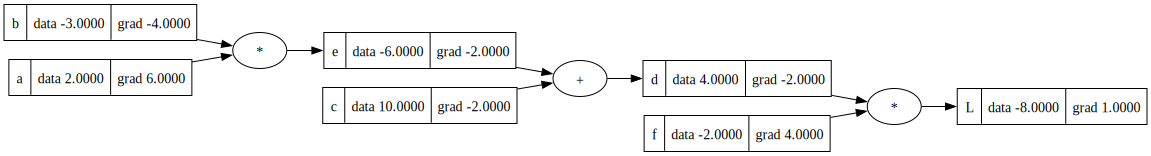

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

L.grad = 1.0
f.grad = dLdf
d.grad = dLdd
e.grad = dLde
c.grad = dLdc
a.grad = dLda
b.grad = dLdb

draw_dot(L)